In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [2]:
import sklearn

In [3]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [4]:
pos_final_test = pd.read_csv('./data/pos_final_test.csv.gz', compression='gzip')

model_cols = pos_final_test.columns.str.contains('abn') | pos_final_test.columns.isin(['gender', 'age','ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN'])
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

# pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') |pos_final_test.columns.str.contains('above') |

In [5]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

In [6]:
hadm_features

,"('abn_percent', 50868)","('abn_percent', 50882)","('abn_percent', 50902)","('abn_percent', 50912)","('abn_percent', 50931)","('abn_percent', 50971)","('abn_percent', 50983)","('abn_percent', 51006)","('abn_percent', 51221)","('abn_percent', 51222)","('abn_percent', 51248)","('abn_percent', 51249)","('abn_percent', 51250)","('abn_percent', 51265)","('abn_percent', 51277)","('abn_percent', 51279)","('abn_percent', 51301)",gender,age,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC/LATINO,ethnicity_OTHER,ethnicity_UNKNOWN
0,0.992148,2.971940,-0.185223,1.796065,1.092715,-0.358973,1.518875,1.820375,0.366535,0.319584,-0.603395,-0.620344,-0.442628,0.205057,-0.477265,0.695477,1.779490,0.0,1.153246,0,0,0,0,0,1
1,-0.313839,-0.497671,1.352803,0.450715,0.276736,-0.358973,-0.375382,-0.721625,0.792468,0.781058,-0.603395,2.166124,1.371060,-0.578435,-0.477265,0.695477,-0.289134,0.0,-0.441483,0,0,0,0,0,0
2,-0.313839,0.359023,3.232613,1.651921,1.092715,0.322577,1.708301,1.502625,-1.550162,-1.526309,1.588998,-0.620344,2.580186,-0.219335,-0.477265,0.695477,0.163378,1.0,1.359017,0,0,0,0,0,0
3,-0.313839,-0.497671,-0.527006,-0.510250,-1.355224,-0.358973,-0.375382,-0.721625,0.792468,0.781058,1.902197,-0.620344,2.580186,-0.578435,-0.477265,0.695477,-0.806290,0.0,-1.316012,0,0,0,0,0,0
4,-0.313839,-0.497671,-0.527006,-0.510250,1.092715,-0.358973,-0.375382,-0.721625,-1.550162,0.781058,-0.603395,-0.620344,-0.442628,-0.578435,-0.477265,0.695477,1.779490,0.0,-1.110241,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8555,-0.313839,-0.497671,-0.527006,-0.510250,-1.355224,-0.358973,-0.375382,-0.721625,-1.550162,0.781058,-0.603395,-0.620344,-0.442628,-0.578435,-0.477265,0.695477,-0.806290,1.0,-0.132826,0,0,0,0,1,0
8556,-0.313839,-0.497671,-0.527006,2.372644,-1.355224,-0.358973,-0.375382,1.820375,0.792468,0.781058,1.902197,-0.620344,2.580186,-0.578435,-0.477265,0.695477,-0.806290,0.0,1.050360,0,0,0,0,0,0
8557,-0.313839,1.858238,2.814877,-0.510250,1.092715,-0.358973,4.833825,-0.721625,0.792468,0.781058,-0.603395,-0.620344,2.580186,-0.578435,-0.477265,0.695477,0.055637,0.0,1.564789,0,1,0,0,0,0
8558,2.329231,-0.405883,1.263288,-0.510250,0.859578,-0.034425,2.229222,1.336184,0.723567,0.781058,-0.603395,0.035296,-0.442628,1.618415,2.341310,0.695477,0.030286,0.0,0.433046,0,0,0,0,0,0


## Train test split

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [8]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [9]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7362
Target=1:  1198


In [10]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))

In [11]:
def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='roc_auc',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('roc_auc')

## Logistic Regression

### Basic

In [12]:
%%time

params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log.fit(X_train, y_train)

CPU times: user 4 s, sys: 488 ms, total: 4.49 s
Wall time: 4.6 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.06210526315789474}
Best CV score:  0.8317
Accuracy Score: 74.94%
_______________________________________________
Classification Report:	Precision Score: 32.34%
			Recall Score: 72.08%
			F1 score: 44.65%
			ROC_AUC score: 73.75%
_______________________________________________
Confusion Matrix: 
 [[1110  362]
 [  67  173]]



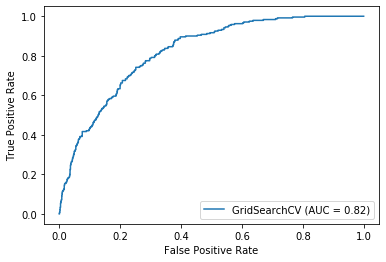

age                                 0.892037
('abn_percent', 51006)              0.386606
('abn_percent', 51277)              0.360276
('abn_percent', 51221)              0.318521
('abn_percent', 50912)              0.293937
('abn_percent', 51222)              0.287607
('abn_percent', 50931)              0.204107
('abn_percent', 51249)              0.138824
ethnicity_BLACK/AFRICAN AMERICAN    0.136301
gender                              0.123855
('abn_percent', 51301)              0.058391
('abn_percent', 50971)              0.058189
('abn_percent', 51250)              0.041333
('abn_percent', 50882)              0.038265
('abn_percent', 51248)              0.036729
('abn_percent', 51279)              0.023386
('abn_percent', 50902)              0.019160
('abn_percent', 50868)              0.016249
dtype: float64


In [13]:
results(grid_log)

In [15]:
# from sklearn.feature_selection import RFECV
# selector = RFECV(grid_log, step=1, cv=5)
# selector = selector.fit(X_train, y_train)
# selector.support_

### Over Sampling using SMOTE

In [16]:
%%time
params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_over = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_over.fit(X_res_over, y_res_over)

CPU times: user 5.4 s, sys: 679 ms, total: 6.08 s
Wall time: 7.22 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.16631578947368422}
Best CV score:  0.8528
Accuracy Score: 75.00%
_______________________________________________
Classification Report:	Precision Score: 31.85%
			Recall Score: 68.75%
			F1 score: 43.54%
			ROC_AUC score: 72.38%
_______________________________________________
Confusion Matrix: 
 [[1119  353]
 [  75  165]]



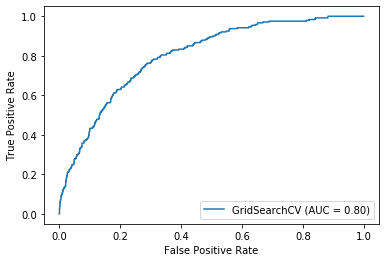

ethnicity_ASIAN                     2.069456
ethnicity_OTHER                     1.717986
ethnicity_UNKNOWN                   1.565860
ethnicity_HISPANIC/LATINO           1.361374
ethnicity_BLACK/AFRICAN AMERICAN    1.111983
age                                 0.955484
('abn_percent', 51222)              0.493492
('abn_percent', 51221)              0.423971
('abn_percent', 51277)              0.395438
('abn_percent', 51006)              0.385960
('abn_percent', 50912)              0.292461
('abn_percent', 50931)              0.273107
('abn_percent', 51248)              0.124859
gender                              0.124628
('abn_percent', 51249)              0.123631
('abn_percent', 51301)              0.110964
('abn_percent', 50971)              0.108175
('abn_percent', 51250)              0.075846
('abn_percent', 51279)              0.074967
('abn_percent', 50868)              0.033288
('abn_percent', 51265)              0.030131
('abn_percent', 50902)              0.013179
('abn_perc

In [17]:
results(grid_log_over)

### Under Sampling using Near Miss

In [18]:
%%time
params ={'C':np.linspace(1e-2,100,100)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_under = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_under.fit(X_res_under, y_res_under)

CPU times: user 12.3 s, sys: 1.16 s, total: 13.5 s
Wall time: 12.6 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01,
       1.213e+01, 1.314e+01, 1.415e+01, 1.516e+01, 1.617e+01, 1.718e+01,
       1.819e+01, 1.920e+01, 2.021e+01...
       6.667e+01, 6.768e+01, 6.869e+01, 6.970e+01, 7.071e+01, 7.172e+01,
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 1.02}
Best CV score:  0.9412
Accuracy Score: 55.67%
_______________________________________________
Classification Report:	Precision Score: 21.76%
			Recall Score: 83.33%
			F1 score: 34.51%
			ROC_AUC score: 67.24%
_______________________________________________
Confusion Matrix: 
 [[753 719]
 [ 40 200]]



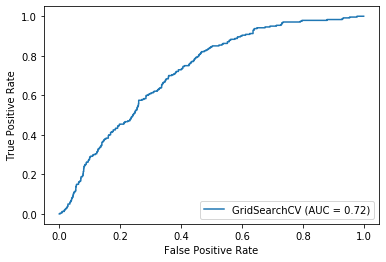

('abn_percent', 50868)              1.821568
('abn_percent', 50983)              1.136129
('abn_percent', 50882)              1.106942
('abn_percent', 51221)              1.102847
('abn_percent', 50971)              1.080486
('abn_percent', 51250)              0.947870
ethnicity_ASIAN                     0.870789
('abn_percent', 50902)              0.776743
ethnicity_BLACK/AFRICAN AMERICAN    0.760961
age                                 0.756521
('abn_percent', 51249)              0.750003
ethnicity_UNKNOWN                   0.719537
('abn_percent', 51277)              0.706791
('abn_percent', 51222)              0.666316
('abn_percent', 51248)              0.537390
('abn_percent', 51265)              0.495462
('abn_percent', 51006)              0.494300
ethnicity_OTHER                     0.425410
('abn_percent', 51301)              0.373401
('abn_percent', 50912)              0.213358
ethnicity_HISPANIC/LATINO           0.166281
gender                              0.102161
('abn_perc

In [19]:
results(grid_log_under)

## Random Forest

### RF_Over Sampling using SMOTE

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 35, 3) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


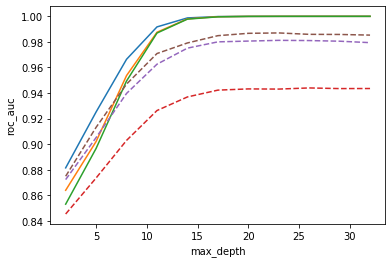

In [30]:
plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,35,3), X_res_over, y_res_over)

In [27]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(120,121,1),
            'max_depth': range(12,22,3)
            }

grid_rf_over = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_over.fit(X_res_over, y_res_over)

CPU times: user 26.2 s, sys: 766 ms, total: 26.9 s
Wall time: 37.3 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(12, 22, 3),
                         'n_estimators': range(120, 121)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 21, 'n_estimators': 120}
Best CV score:  0.9707
Accuracy Score: 83.94%
_______________________________________________
Classification Report:	Precision Score: 42.68%
			Recall Score: 42.50%
			F1 score: 42.59%
			ROC_AUC score: 66.60%
_______________________________________________
Confusion Matrix: 
 [[1335  137]
 [ 138  102]]



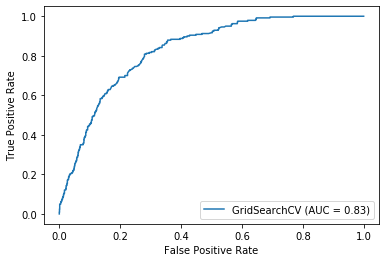

age                                        0.164344
('abn_percent', 51006)                     0.137250
('abn_percent', 50912)                     0.106182
('abn_percent', 50931)                     0.072303
('abn_percent', 50882)                     0.054669
('abn_percent', 51277)                     0.047767
('abn_percent', 50902)                     0.045974
gender                                     0.040721
('abn_percent', 51249)                     0.039990
('abn_percent', 51301)                     0.039506
('abn_percent', 51265)                     0.029360
('abn_percent', 51221)                     0.027776
('abn_percent', 50983)                     0.026435
('abn_percent', 50971)                     0.024910
('abn_percent', 50868)                     0.023811
('abn_percent', 51279)                     0.023223
('abn_percent', 51222)                     0.022195
('abn_percent', 51248)                     0.021598
('abn_percent', 51250)                     0.018902
ethnicity_UN

In [28]:
results(grid_rf_over)

### RF_Under Sampling using Near Miss

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 35, 3) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


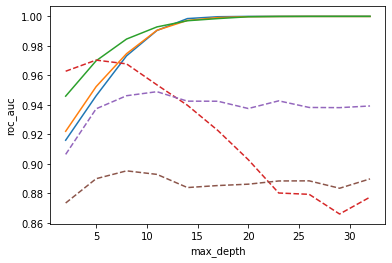

In [29]:
plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,35,3), X_res_under, y_res_under)

In [31]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(420,421,1),
            'max_depth': range(2,9,2)
            }

grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_under.fit(X_res_under, y_res_under)

CPU times: user 13.4 s, sys: 351 ms, total: 13.8 s
Wall time: 19.9 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(2, 9, 2),
                         'n_estimators': range(420, 421)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 420}
Best CV score:  0.9355
Accuracy Score: 57.42%
_______________________________________________
Classification Report:	Precision Score: 22.44%
			Recall Score: 82.92%
			F1 score: 35.31%
			ROC_AUC score: 68.09%
_______________________________________________
Confusion Matrix: 
 [[784 688]
 [ 41 199]]



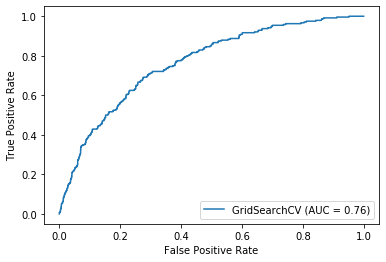

('abn_percent', 51006)                     0.169464
('abn_percent', 50912)                     0.137819
('abn_percent', 50882)                     0.135634
('abn_percent', 51277)                     0.079851
('abn_percent', 50902)                     0.073060
('abn_percent', 51250)                     0.072042
('abn_percent', 51249)                     0.063890
('abn_percent', 51248)                     0.058972
('abn_percent', 50971)                     0.046582
('abn_percent', 50868)                     0.033874
('abn_percent', 50983)                     0.032635
age                                        0.024264
('abn_percent', 51265)                     0.023545
('abn_percent', 51301)                     0.018090
('abn_percent', 51222)                     0.008125
('abn_percent', 51221)                     0.006833
('abn_percent', 50931)                     0.005932
('abn_percent', 51279)                     0.004925
gender                                     0.001897
ethnicity_BL

In [32]:
results(grid_rf_under)

## Gradient Boost

### GB_Over Sampling using SMOTE¶

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(3, 20, 5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


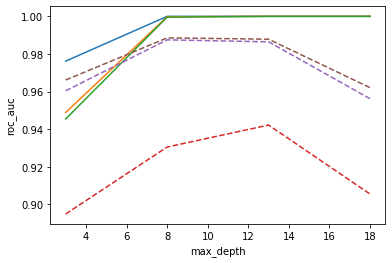

In [34]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(3,20,5), X_res_over, y_res_over)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_features, param_range=range(5, 30, 5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


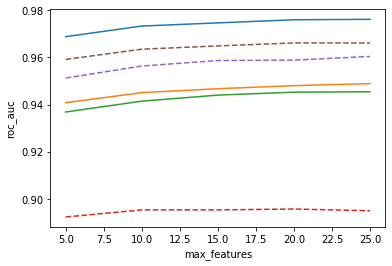

In [33]:
plot_val_curve(GradientBoostingClassifier(), 'max_features', range(5,30,5), X_res_over, y_res_over)

In [36]:
%%time
param_grid={'n_estimators':range(250,251,10),
            'max_depth':range(8,13,1),
            }

grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_over.fit(X_res_over, y_res_over)

CPU times: user 6min 56s, sys: 6.45 s, total: 7min 3s
Wall time: 8min 25s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(8, 13),
                         'n_estimators': range(250, 251, 10)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'max_depth': 11, 'n_estimators': 250}
Best CV score:  0.9766
Accuracy Score: 83.06%
_______________________________________________
Classification Report:	Precision Score: 37.98%
			Recall Score: 32.92%
			F1 score: 35.27%
			ROC_AUC score: 62.08%
_______________________________________________
Confusion Matrix: 
 [[1343  129]
 [ 161   79]]



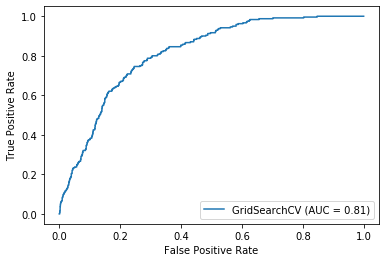

('abn_percent', 51006)                     0.289243
age                                        0.170176
('abn_percent', 50931)                     0.060923
('abn_percent', 50912)                     0.059672
('abn_percent', 50882)                     0.040586
gender                                     0.039333
('abn_percent', 51249)                     0.033227
('abn_percent', 51277)                     0.033139
('abn_percent', 51301)                     0.032348
('abn_percent', 50902)                     0.029663
('abn_percent', 51221)                     0.025233
('abn_percent', 51265)                     0.024967
('abn_percent', 50971)                     0.023041
('abn_percent', 50983)                     0.022645
('abn_percent', 51279)                     0.020133
('abn_percent', 50868)                     0.019018
('abn_percent', 51248)                     0.016717
('abn_percent', 51250)                     0.016403
('abn_percent', 51222)                     0.014375
ethnicity_UN

In [37]:
results(grid_gb_over)

In [38]:
# %%time
# param_grid={'n_estimators':range(150,151,1),
#             'max_depth':range(13,14,1),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(8,17,2),
#             }
# # 'max_depth': 9, 'n_estimators': 80
# grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_over.fit(X_res_over, y_res_over)

In [39]:
# results(grid_gb_over)

### GB_Under Sampling using Near Miss

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 30, 5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


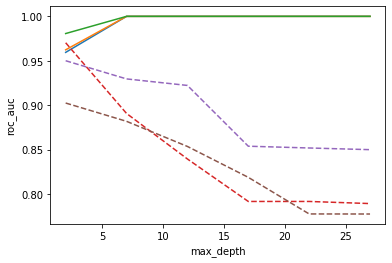

In [42]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(2,30,5), X_res_under, y_res_under)

In [43]:
%%time
param_grid={'n_estimators':range(400,401,1),
            'max_depth':range(2,5,1),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_under.fit(X_res_under, y_res_under)

CPU times: user 12.4 s, sys: 329 ms, total: 12.7 s
Wall time: 17.8 s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(2, 5),
                         'n_estimators': range(400, 401)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'max_depth': 2, 'n_estimators': 400}
Best CV score:  0.9333
Accuracy Score: 50.88%
_______________________________________________
Classification Report:	Precision Score: 20.34%
			Recall Score: 85.83%
			F1 score: 32.88%
			ROC_AUC score: 65.50%
_______________________________________________
Confusion Matrix: 
 [[665 807]
 [ 34 206]]



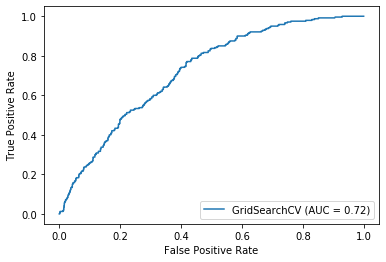

('abn_percent', 51006)                     0.251784
('abn_percent', 50912)                     0.129576
('abn_percent', 50882)                     0.103898
('abn_percent', 51277)                     0.088814
('abn_percent', 51250)                     0.066096
('abn_percent', 51249)                     0.061737
('abn_percent', 51248)                     0.058802
('abn_percent', 50902)                     0.045636
age                                        0.034359
('abn_percent', 50971)                     0.029338
('abn_percent', 51265)                     0.024086
('abn_percent', 50868)                     0.022666
('abn_percent', 51301)                     0.022313
('abn_percent', 50983)                     0.020235
('abn_percent', 51221)                     0.012055
('abn_percent', 51279)                     0.007285
('abn_percent', 51222)                     0.006674
('abn_percent', 50931)                     0.006583
gender                                     0.002633
ethnicity_BL

In [44]:
results(grid_gb_under)

In [45]:
# %%time
# param_grid={'n_estimators':range(80,81,1),
#             'max_depth':range(2,9,2),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(7,12,2),
#             }

# grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_under.fit(X_res_under, y_res_under)

In [46]:
# results(grid_gb_under)

In [41]:
# from xgboost.sklearn import XGBClassifier

In [40]:
# param_grid = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 0.5),
#     "learning_rate": uniform(0.03, 0.3), # default 0.1 
#     "max_depth": randint(2, 6), # default 3
#     "n_estimators": randint(100, 150), # default 100
#     "subsample": uniform(0.6, 0.4)
# }


# grid_xgb_under = RandomizedSearchCV(XGBClassifier(), param_distributions=params,  n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True, scoring='roc_auc')
# search.fit(X_res_under, y_res_under)

## Gather Metrics

In [47]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for model, model_name in model_list:
        pred = model.best_estimator_.predict(X_test)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        metrics = metrics.append({'Model':model_name,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)        
    return metrics

In [49]:
model_list=[(grid_log,'logistic_basic'),(grid_log_under,'logistic_under'),(grid_log_over,'logistic_over'), 
            (grid_gb_under,'gradient_boost_under'),(grid_gb_over,'gradient_boost_over'),
            (grid_rf_under,'random_forest_under'),(grid_rf_over,'random_forest_over')
           ]
gather_metrics(model_list)

,Model,F1,ROC_AUC,Recall,Accuracy,Precision
0,logistic_basic,0.446452,0.737455,0.720833,0.749416,0.323364
1,logistic_under,0.345125,0.672441,0.833333,0.556659,0.217628
2,logistic_over,0.435356,0.723845,0.687500,0.750000,0.318533
3,gradient_boost_under,0.328811,0.655050,0.858333,0.508762,0.203356
4,gradient_boost_over,0.352679,0.620765,0.329167,0.830607,0.379808
5,random_forest_under,0.353150,0.680888,0.829167,0.574182,0.224352
6,random_forest_over,0.425887,0.665965,0.425000,0.839369,0.426778


## Gather Best Features

In [ ]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

In [ ]:
gather_best_features(model_list)